# General information
 * Author: Joris Busink, Junior Teacher Physics Education.
 * Date: Monday, 8th August.
 * About: FFT Data processing script for high-speed camera. 

## Load packages
I load the following packages: numpy, matplotlib.pyplot, pandas. These pacakges are always usefull in doing nummerical calculations using Python. In a later stage, I will use the functions Curve_fit, fft, rfft and rfftfreq. I load these in as well.

In [1]:
# %matplotlib widget 
#requires package ipympl installed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.fft import fft, rfft,rfftfreq
np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display.

cwd = os.getcwd()
cwd= os.path.split(os.getcwd())[0]

## Read data
In this section we read in the raw data, furthermore, I do some small filtering in the data. 
<br>
### Necessary commands
 * Line 1: make dataframe 'df' that contains all data.<br>
 * Line 3-5: change the nummerical separator from a comma to a dot (In the Netherlands we use comma, international standard is a dot.)<br>
 * Line 6-7: remove "Not-a-Number", nan, values from the list.<br>

### Optional commands
* Line 8-10: make a subselection of the data. Handling large datafiles can be very slow and annoying. 
<br>


In [2]:
df=pd.read_csv(cwd+'/data/Slingerdata_1.mqa', sep='\t',header=0)
Time = df['Time'].str.replace(',', '.').astype(float).to_list()
Xpos = df['Point #1.X'].str.replace(',', '.').astype(float).to_list()
Ypos = df['Point #1.Y'].str.replace(',', '.').astype(float).to_list()
Xpos = [x for x in Xpos if str(x) != 'nan']
Ypos = [x for x in Ypos if str(x) != 'nan']
t=np.asarray(Time[:15000])
scaling = 1/1000 #scaling factor from pixel to [m]
x = np.asarray(Xpos[0:15000])*scaling 
y = np.asarray(Ypos[0:15000])*scaling 

## Define model + fit
In this section I do two different things. First, I define a function that is composed of two sines. The reason for this is the following: <br>
If we would captures the pendulum data perfectly in-plane, we would only have a single frequency $\omega_{n,1}$ in our signal. However, what would happen if we would have a small incline? In principle, we would just have a smaller amplitude, however,
we are dealing with a real physical system. A small out-of-plane amplitude changes the reflection of the light onto the pendulum, this results in a frequency $\omega_{n,2}$. This frequency is twice the original frequency (why?). Therefore, we define our model:

 * $x(t) = x_0 + A_1 \sin(\omega_{n,1} t +\phi_1) + A_2 \sin(\omega_{n,2} +\phi_2)$,

 with $\omega_{n,1} = 2\omega_{n,2}$, that represents the natural frequency $\omega_{n,1}^2 = g/l$ of the system.

 In the second part of this section, I calculate the Fourier transform of the signal, more precisly the FFT.

 The Fourier transform of our orignal function is:
  * $ x(\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x(t)e^{i\omega t}d\omega$ 
  * $ x(\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}(x_0 + A_1 \sin(\omega_{n,1} t +\phi_1) + A_2 \sin(\omega_{n,2} +\phi_2) )e^{i\omega t}d\omega$
  * $ x(\omega) = \frac{1}{\sqrt{2\pi}}[ x_0\sqrt{2\pi} \delta(\omega) + \frac{A_1 \sqrt{2\pi} }{2i} (\delta(\omega-\omega_{n,1})-\delta(\omega+\omega_{n,1}))+ \frac{A_2 \sqrt{2\pi} }{2i} (\delta(\omega-\omega_{n,2})-\delta(\omega+\omega_{n,2}))]$

  We notice that we have an offset to our signal $x_0\delta(\omega)$ and that we are dealing with complex numbers. <br>
  Therefore, we take we subtract the mean of our signal and take the absolute values. We are left with the frequency spectrum of our original data.
  

[0.3019 0.2267 0.6553 0.4978]


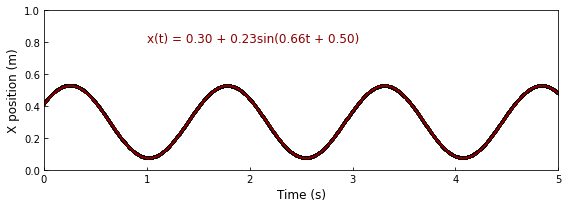

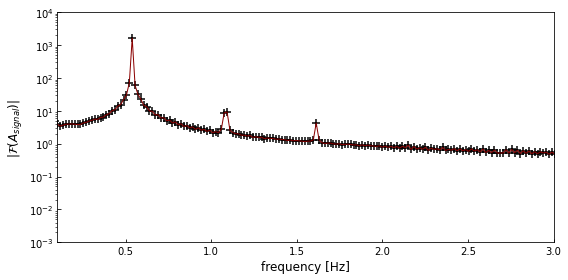

In [3]:

def model(x,a,b,c,d):
    return a+b*np.sin(2*np.pi*c*x+d)
def model1(x,a,b,c,d,e,f,g):
    return a+b*np.sin(c*x+d)+e*np.sin(f*x+g)

popt, pcov = curve_fit(model,t[0:1000],x[0:1000],p0=[0.6,0.1,4/6,0])
fig,axes=plt.subplots(1,1,figsize=(8,3))
axes.scatter(t[0::1],x[0::1], color = 'black', s = 15, marker ='+')
axes.plot(np.linspace(0,5,1001),model(np.linspace(0,5,1001),*popt), color ='darkred', lw = 2)
axes.set_xlim(0,5)
axes.set_ylim(0,1)
axes.set_xlabel('Time (s)', fontsize=12)
axes.set_ylabel('X position (m)',fontsize=12)
axes.tick_params(direction="in")
print(popt)
# axes.text(1,0.25,r"$f(t) = x_{0} + A(t)\cdot\sin(\omega t+\phi)$", color = 'black', fontsize=12)
axes.text(1,0.8,"x(t) = " + "{:.2f}".format(popt[0]) +" + "+ "{:.2f}".format(popt[1])
          +r"sin(" +"{:.2f}".format(popt[2])+ "t + "+"{:.2f}".format(popt[3]) + ")"  , color = 'darkred', fontsize=12)
plt.tight_layout()
plt.show()


# Number of sample points
fps= 126
A_signal_fft = rfft(np.asarray(x)-np.mean(x))
frequencies = rfftfreq(np.size(t),1/(2*fps))

fig,axes=plt.subplots(1,1, figsize=(8,4))
axes.plot(frequencies, np.abs(A_signal_fft), lw=1, c='darkred')
axes.scatter(frequencies, np.abs(A_signal_fft), s=50, c='black',marker='+')
# print(frequencies*2*np.pinp.argmax())
axes.set_xlim(.1,3)
axes.set_ylim(0.001,10000)
axes.set_yscale('log')
# axes.set_xscale('log')

axes.set_xlabel("frequency [Hz]",fontsize=12)
axes.set_ylabel(r"$|\mathcal{F}(A_{signal})|$",fontsize=12)
axes.tick_params(direction="in")
# plt.savefig('Munib/FFT_Mean_Slinger_Ydirection.svg')
plt.tight_layout()
plt.show()


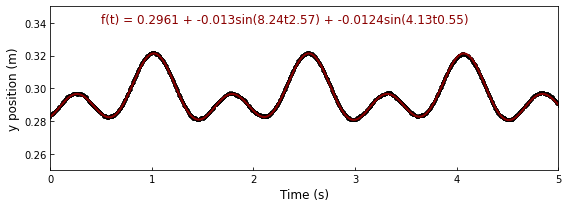

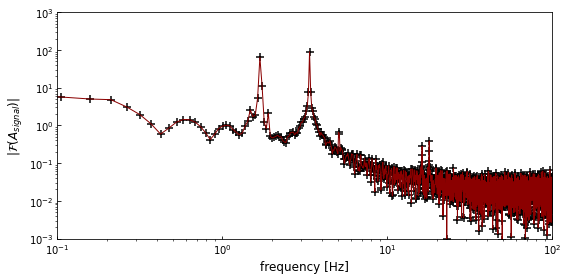

In [4]:
popt, pcov = curve_fit(model1,t[0:1000],y[0:1000],p0=[0.394,0.05,9.2,0,0.01,4.6,0])

fig,axes=plt.subplots(1,1,figsize=(8,3))
axes.scatter(t[0::1],y[0::1], color = 'black', s = 15, marker ='+')
axes.plot(np.linspace(0,5,1001),model1(np.linspace(0,5,1001),*popt), color ='darkred', lw = 2)

axes.set_xlim(0,5)
axes.set_ylim(0.25,0.35)

axes.set_xlabel('Time (s)', fontsize=12)
axes.set_ylabel('y position (m)',fontsize=12)
axes.tick_params(direction="in")
# axes.text(1,0.25,r"$f(t) = x_{0} + A(t)\cdot\sin(\omega t+\phi)$", color = 'black', fontsize=12)
axes.text(0.5,0.34,"f(t) = " + "{:.4f}".format(popt[0]) +" + "+ "{:.3f}".format(popt[1])
          +r"sin(" +"{:.2f}".format(popt[2])+ "t"+"{:.2f}".format(popt[3]) + ")"  +" + "+ "{:.4f}".format(popt[4])
          +r"sin(" +"{:.2f}".format(popt[5])+ "t"+"{:.2f}".format(popt[6]) + ")"  , color = 'darkred', fontsize=12)
plt.tight_layout()
plt.show()

# Number of sample points
A_signal_fft = rfft(np.asarray(y)-np.mean(y))
frequencies = rfftfreq(np.size(t),1/126.)

fig,axes=plt.subplots(1,1, figsize=(8,4))
axes.plot(frequencies*2*np.pi, np.abs(A_signal_fft), lw=1, c='darkred')
axes.scatter(frequencies*2*np.pi, np.abs(A_signal_fft), s=50, c='black',marker='+')

axes.set_xlim(.1,100)
axes.set_ylim(0.001,1000)
axes.set_yscale('log')
axes.set_xscale('log')

axes.set_xlabel("frequency [Hz]",fontsize=12)
axes.set_ylabel(r"$|\mathcal{F}(A_{signal})|$",fontsize=12)
axes.tick_params(direction="in")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def acor(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2.:]
# generate some data
time = np.arange(0.,6*np.pi,0.01)
y = np.sin(time)

from numpy import *
import numpy as N
import pylab as P



def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = N.correlate(x, x, mode = 'full')[-n:]
    #assert N.allclose(r, N.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(N.arange(n, 0, -1)))
    return result

P.plot(time,estimated_autocorrelation(y))
P.plot(time,y)

P.xlabel('time (s)')
P.ylabel('autocorrelation')
P.show()

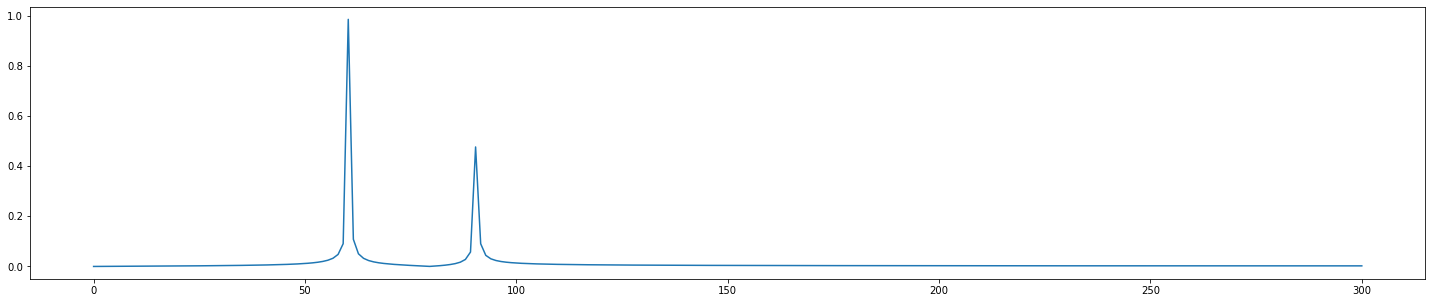

In [7]:
import matplotlib.pyplot as plt
import numpy as np

N = 500
T = 1.0 / 600.0
x = np.linspace(0.0, N*T, N)
y = np.sin(60.0 * 2.0*np.pi*x) + 0.5*np.sin(90.0 * 2.0*np.pi*x)
y_f = np.fft.fft(y)
x_f = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig,axes =plt.subplots(1,1,figsize=(25,5))
axes.plot(x_f, 2.0/N * np.abs(y_f[:N//2]))
plt.show()

A_signal_fft = rfft(np.asarray(x)-np.mean(x))
frequencies = rfftfreq(np.size(t),1/(2*fps))